In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os, warnings

import cosima_cookbook as cc

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 11.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35373,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 11.23 GiB
Comm: tcp://127.0.0.1:44591,Total threads: 1
Dashboard: /proxy/45537/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:45123,


In [36]:
# -- regional average
def wgt_areaave(indat, latS, latN, lonW, lonE):
  lat=indat.yt_ocean
  lon=indat.xt_ocean

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     lon=( (lon + 180) % 360 - 180)
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)

#  print(iplat)
#  print(iplon)
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(yt_ocean=iplat,xt_ocean=iplon).weighted(wgt).mean(("xt_ocean", "yt_ocean"), skipna=True)
  return(odat)


In [3]:
db = 'local_cc_test.db'
session = cc.database.create_session(db)

In [4]:
from collections import OrderedDict
exptdict = OrderedDict([
    ('HI-00', # original historical run
     {'model': 'ACCESS-ESM 1.5', 'expt': 'HI-00',
      'n_files': -12, 'itime': '1850-01-14', 'ftime': None}),
    ('HI-02', # Pacific Pacemaker historical run
     {'model': 'ACCESS-ESM 1.5', 'expt': 'HI-02',
      'n_files': -12, 'itime': '1850-01-14', 'ftime': None}),
])

In [25]:
# Function to extract and load SST and SSS from the models, WOA13
ekeys = ['HI-00', 'HI-02']
for ekey in ekeys:
    e = exptdict[ekey]
    # Load surface temperature from model
    surface_temp = cc.querying.getvar(e['expt'], 'pot_temp', session,
                            n=e['n_files'], ncfile='ocean_month.nc',
                 start_time=e['itime'], end_time=e['ftime']).isel(st_ocean=0)

    # Extract a year range string and print (for title string):
    e['yearrange'] = "{} to {}".format(
        surface_temp.time.dt.strftime("%Y-%m").item(0),
        surface_temp.time.dt.strftime("%Y-%m").item(-1),
    )
    print(f"{ekey}: {e['yearrange']}")

    # Add SST to dictionary
    e['SST'] = surface_temp.mean('time').load()
    e['SST_std'] = surface_temp.std('time').load()


HI-00: 1863-01 to 1874-12


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


HI-02: 1863-01 to 1874-12


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [29]:
surface_temp = cc.querying.getvar('HI-02', 'pot_temp', session,
                            n=e['n_files'], ncfile='ocean_month.nc',
                 start_time=e['itime'], end_time=e['ftime']).isel(st_ocean=0)

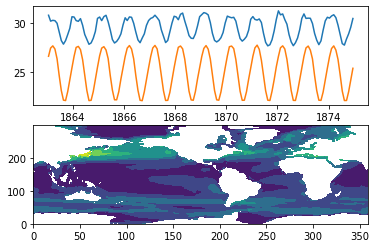

In [61]:
date = surface_temp.time
yyyy = date.time.dt.year
mm = date.time.dt.month
dd = date.time.dt.day
yyyymmdd = yyyy+(mm-1)/12+dd/365

mask_box=wgt_areaave(surface_temp,-15,-5,-90,-85)
other_box=wgt_areaave(surface_temp,-15,-5,-240,-220)
plt.subplot(211)
plt.plot(yyyymmdd,other_box, yyyymmdd,mask_box)
plt.subplot(212)
plt.contourf( surface_temp.std('time').values )

In [17]:
# Calculate bias and add to dictionary
# SST_anom = e['SST'] - e['SST_WOA13'].values

e = exptdict['HI-00']
sst_00 = e['SST_std']
e = exptdict['HI-02']
sst_02 = e['SST_std']
sst_diff = sst_00 - sst_02

In [23]:
%cd /home/599/ars599/Documents/a10/
figdir = '.'
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

/home/599/ars599/Documents/a10


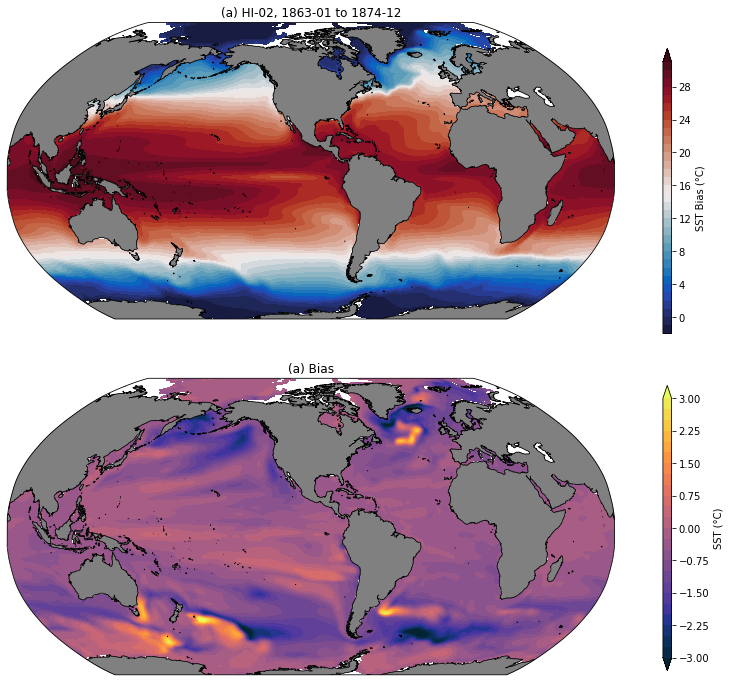

In [28]:
# Plot IAF and RYF SST biases at 3 resolutions:
fig = plt.figure(figsize=(12,12))

clev = np.arange(-3,3.25,0.25)
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray', linewidth=0.5)

ax1 = plt.subplot(2,1,1,projection=ccrs.Robinson(central_longitude=-100))
ax1.coastlines(resolution='50m')
ax1.add_feature(land_50m)
pn = sst_02.plot.contourf(cmap=cm.cm.balance, levels=np.arange(-2.,32.,1.), add_colorbar=False, transform=ccrs.PlateCarree())
plt.title("({}) {}, {}".format(chr(ord('a') + 0), 'HI-02', e['yearrange']))

p0 = pn

ax1 = plt.subplot(2, 1, 2, projection=ccrs.Robinson(central_longitude=-100))
ax1.coastlines(resolution='50m')
ax1.add_feature(land_50m)
pn = sst_diff.plot.contourf(cmap=cm.cm.thermal,levels=clev,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title("({}) Bias".format(chr(ord('a') + 0)))

ax5 = plt.axes([0.92,0.52,0.01,0.33])
cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
cb.ax.set_ylabel('SST Bias (°C)')

ax6 = plt.axes([0.92,0.13,0.01,0.33])
cb = plt.colorbar(pn, cax=ax6, orientation='vertical')
cb.ax.set_ylabel('SST (°C)')

savefigure('SST_bias_Pac')